<a href="https://colab.research.google.com/github/connorhuis/PredictingWaveHeights/blob/main/CurrentCleanWavePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Prologue**

#### I am currently a student in my last semester of college studying buisness analytics and data science. I am the early stages of hopefully a long career of building models and having fun with data. I want to test my skills with time series predictions using an array of models including ARIMA and tensorflow. This is real life data taken from the National Data Buoy Center which I pulled using the website. I am going to try predicting wave height using a variety of varaibles pulled from the buoys. There is many applications where this could useful. I may evantually expand this to help predict dangerous conditions such as rip currents and other dangerous conditions.

In [ ]:
# Grabbed wave measurments from https://www.ndbc.noaa.gov/view_text_file.php?filename=44056h2022.txt.gz&dir=data/historical/stdmet/

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/wave.txt', sep = r'\t', header = None)
df = df[2:] # Take off first two rows since they were labels
split_columns = df.iloc[:,0].str.split(expand=True) # Split data since sep did not work

# Rename the new columns with meaningful names
split_columns.columns = ['YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE']
wavesDF = split_columns
wavesDF['Date'] = wavesDF['YY'] + '/' + wavesDF['MM'] + '/' + wavesDF['DD'] # Create new column Date
wavesDF.drop(columns=['YY', 'MM', 'DD','VIS','TIDE','WDIR','WSPD','GST','PRES','ATMP','WTMP','DEWP'], inplace=True) # Drop columns for non relevant or missing data
wavesDF['Date'] = pd.to_datetime(wavesDF['Date'], format='%Y/%m/%d' )
wavesDF.set_index('Date', inplace = True) # Set dateTime inde
wave = wavesDF

<ipython-input-1-c22f76bc681a>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/drive/MyDrive/wave.txt', sep = r'\t', header = None)


In [ ]:
# Grabbed wind measurments from https://www.ndbc.noaa.gov/download_data.php?filename=dukn7h2022.txt.gz&dir=data/historical/stdmet/

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/wind.txt', sep = r'\t', header = None)
df = df[2:] # Take off first two rows since they were labels
split_columns = df.iloc[:,0].str.split(expand=True) # Split data since sep did not work

# Rename the new columns with meaningful names
split_columns.columns = ['YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE']
windDF = split_columns
windDF['Date'] = windDF['YY'] + '/' + windDF['MM'] + '/' + windDF['DD'] # Create new column Date
windDF.drop(columns=['YY', 'MM', 'DD','WVHT','DPD','APD', 'MWD', 'WTMP', 'DEWP','VIS','TIDE'], inplace=True) # Drop columns for non relevant or missing data

windDF['Date'] = pd.to_datetime(windDF['Date'], format='%Y/%m/%d')
windDF.set_index('Date', inplace = True) # Set dateTime index
wind = windDF

<ipython-input-2-bae1b170e72b>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/drive/MyDrive/wind.txt', sep = r'\t', header = None)


## **Overview of the Data**

I imported a historical graph of bouys readings from the Duck research pier in the Outer Banks of North Carolina. Most bouys do not collect both wind and wave data so I had to get the data from two seperate sources. The wind data is collected every 6 minutes resulting in 240 observations every 24 hours and a total of 87000 rows. The wave data is collected every 30 minutes resulting in 80% less data. In the raw data we have two Pandas data frames which we will join later. For both we have time series data of day, month, year, minute and hour.

For measurments in the Air dataframe we have

* **WDIR** - Wind Direction (Degress)
* **WSPD** - Wind Speed (Knots)
* **GST** - Max Wind Speed in Period (Knots)
* **PRES** - Sea Level Pressure (hPa)
* **ATMP** - Air Temperature (Celsius)

For measurments in the Wave dataframe we have
* **WVHT** - Wave Height (Meters)
* **DPD** - Dominant Wave Period (Seconds)
* **APD** - Average Wave Period (Seconds)
* **MWD** - Direction of MWD (Degrees)

Since we have uneven sizes for the data frame we must even the dataframes out. I elected to take the first and middle recording since waves do not change incredibly drastically over hours as it usually takes days for swells to roll in. This also allows me to cut down on time and power needed to produce a model. Along with that, for some reason there is missing data for periods of time for both buoys. We must make sure that we have data that was recorded at the same time for all the variables. To do that I selected days that contained a filler number (99,999,9999) and replaced them with the value before.

In [ ]:
firstOBSwind = wind.groupby(wind.index.date).first()
secondOBSwind = wind.groupby(wind.index.date).apply(lambda x: x.iloc[len(x) // 2]) # Grab the first and middle observation of every day

windMerged = pd.concat([firstOBSwind,secondOBSwind]).sort_index(kind = 'merge')


In [ ]:
firstOBSwave = wave.groupby(wave.index.date).first()
secondOBSwave = wave.groupby(wave.index.date).apply(lambda x: x.iloc[len(x) // 2]) # Grab the first and middle observation of every day

waveMerged = pd.concat([firstOBSwave,secondOBSwave]).sort_index(kind = 'merge') # Merge data frames together
# waveMerged, windMerged


In [ ]:
# Find indexes that are in waveMerged but not in windMerged
missing_in_windMerged = waveMerged.index.difference(windMerged.index)

# Find indexes that are in windMerged but not in waveMerged
missing_in_waveMerged = windMerged.index.difference(waveMerged.index)

mask = windMerged.index.isin(waveMerged.index)

windMerged1 = windMerged[mask] # Filter wind data frame since waves DF has missing values

# windMerged1, waveMerged

In [ ]:
windWave = pd.concat([windMerged1,waveMerged],axis = 1)
windWave = windWave.drop(columns = ['hh','mm','hh','mm']) #Drop hour/minute variables
windWave = windWave.astype(float)
print(type(windWave))
windWave

<class 'pandas.core.frame.DataFrame'>


,WDIR,WSPD,GST,PRES,ATMP,WVHT,DPD,APD,MWD
2022-01-01,157.0,4.1,4.7,1015.1,12.8,0.63,12.50,7.63,94.0
2022-01-01,196.0,4.8,5.8,1011.9,17.0,0.69,12.50,6.79,87.0
2022-01-02,198.0,8.6,11.3,1007.9,19.8,0.69,13.33,4.84,66.0
2022-01-02,224.0,10.0,13.1,1005.9,19.5,0.80,14.29,4.00,79.0
2022-01-03,270.0,4.9,5.8,1011.1,18.6,0.65,14.29,5.90,71.0
...,...,...,...,...,...,...,...,...,...
2022-12-29,235.0,3.8,3.8,1029.8,4.8,0.56,9.09,8.16,107.0
2022-12-30,190.0,6.0,6.5,1028.2,11.4,0.60,11.11,6.67,96.0
2022-12-30,999.0,99.0,99.0,9999.0,11.1,0.72,9.88,8.59,102.0
2022-12-31,172.0,5.4,6.6,1012.8,17.9,0.73,11.11,6.42,109.0


In [ ]:
import numpy as np
values = [99.0, 999.0, 9999.0]
for col in windWave.columns:
  for value in values:
    mask =(windWave[col] == value)
    # colAvg = windWave.loc[mask,col].mean()
    windWave.loc[mask,col] = np.nan

windWave = windWave.ffill()
windWave = windWave.round(2)
windWave

,WDIR,WSPD,GST,PRES,ATMP,WVHT,DPD,APD,MWD
2022-01-01,157.0,4.1,4.7,1015.1,12.8,0.63,12.50,7.63,94.0
2022-01-01,196.0,4.8,5.8,1011.9,17.0,0.69,12.50,6.79,87.0
2022-01-02,198.0,8.6,11.3,1007.9,19.8,0.69,13.33,4.84,66.0
2022-01-02,224.0,10.0,13.1,1005.9,19.5,0.80,14.29,4.00,79.0
2022-01-03,270.0,4.9,5.8,1011.1,18.6,0.65,14.29,5.90,71.0
...,...,...,...,...,...,...,...,...,...
2022-12-29,235.0,3.8,3.8,1029.8,4.8,0.56,9.09,8.16,107.0
2022-12-30,190.0,6.0,6.5,1028.2,11.4,0.60,11.11,6.67,96.0
2022-12-30,190.0,6.0,6.5,1028.2,11.1,0.72,9.88,8.59,102.0
2022-12-31,172.0,5.4,6.6,1012.8,17.9,0.73,11.11,6.42,109.0


## **Viewing the Data**

We now have a data set that is clean, concated, and with time series indexing. I also elected to take the hours and minutes away as I did not deem them neccassary anymore. Now it is time to plot the data and view correlation to see if we can filter out any obvious signs of multicollinearity or weakly correlated variables.

<ipython-input-8-2a36dff4f12d>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  plot1.plot(kind = 'bar',subplots=True, xticks=[],ax=axes,legend= False)


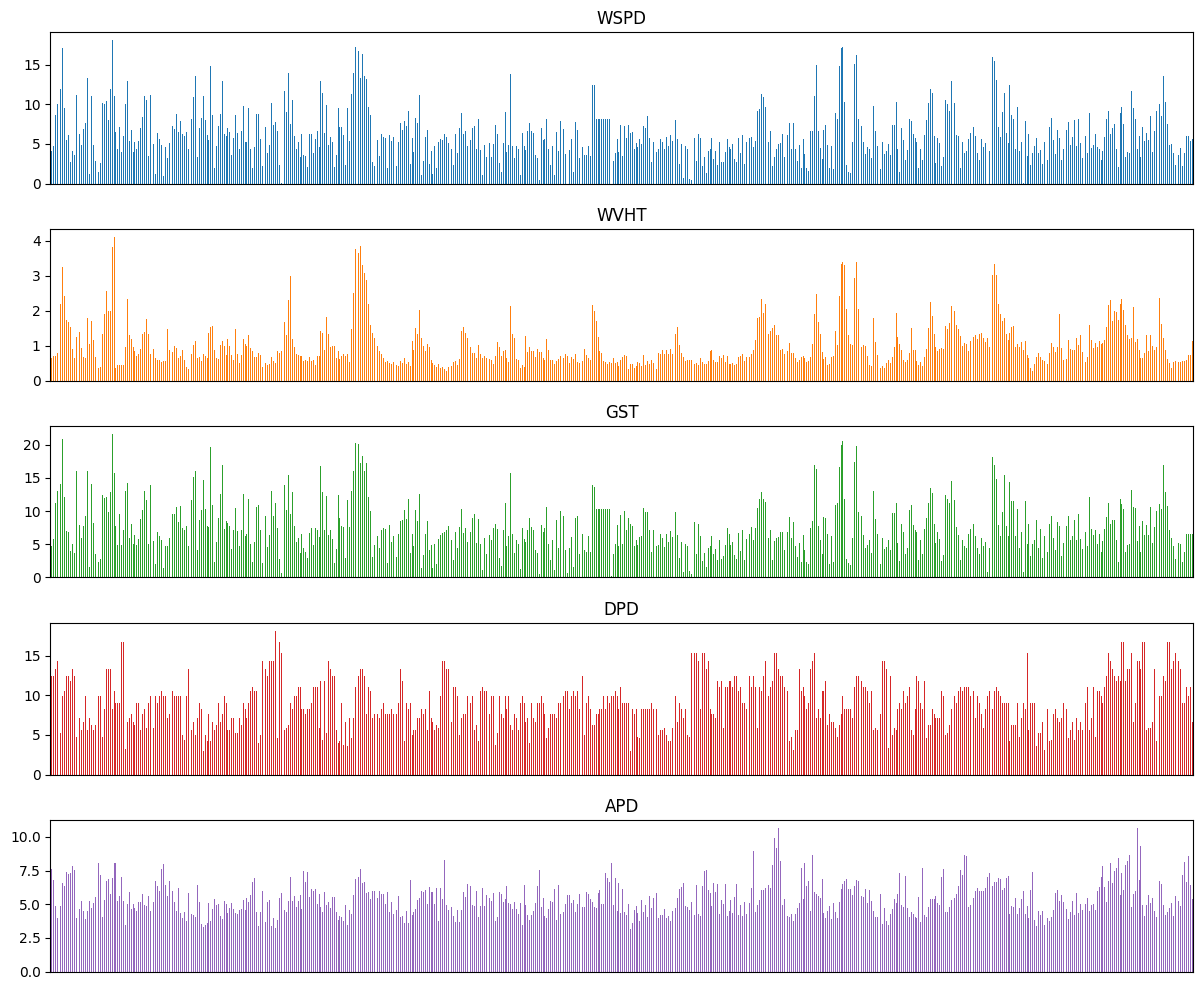

In [ ]:
import matplotlib.pyplot as plt
from datetime import date

windWave = windWave.astype(float) # Convert all data types to floats
plot1 = windWave[['WSPD','WVHT', 'GST','DPD','APD']]

fig, axes = plt.subplots(figsize=(12, 10))
plot1.plot(kind = 'bar',subplots=True, xticks=[],ax=axes,legend= False)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Wave Height [m/s]')

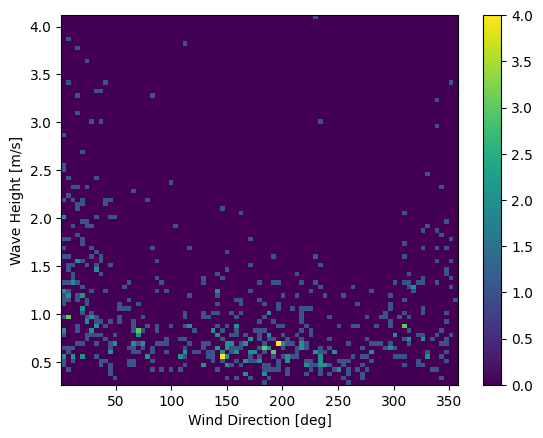

In [ ]:
plt.hist2d(windWave['WDIR'], windWave['WVHT'], bins=(85, 85))
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wave Height [m/s]')

WDIR   -0.224525
WSPD    0.682139
GST     0.662977
PRES   -0.053268
ATMP   -0.269777
WVHT    1.000000
DPD     0.001919
APD     0.256653
MWD    -0.241216
Name: WVHT, dtype: float64


<Axes: >

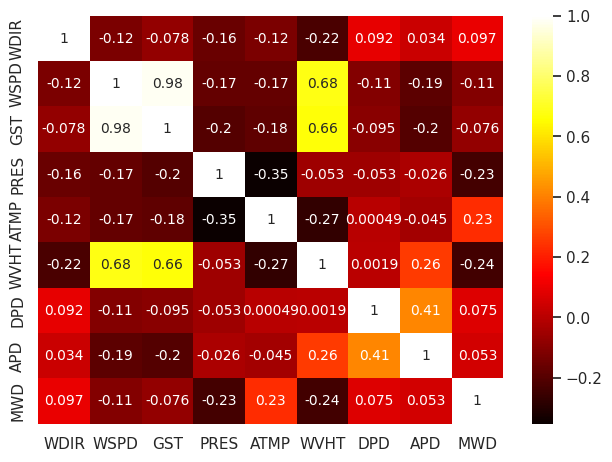

In [ ]:
print(windWave.corr()['WVHT'])
import seaborn as sns
sns.set(rc={'figure.figsize':(7.5,5.3)})
sns.heatmap(windWave.corr(), cmap='hot', annot=True,annot_kws={"size": 10})

In [ ]:
windWave.drop(columns = ['GST','PRES','DPD'], inplace = True);

## **Multicollinarity, Correlation, and Train/Test Splitting**
After viewing the data plots and the correlation we can reduce the data set more to help produce a successful model. After evaluation I determined to take out three variables GST, PRES, and DPD. The reason I took out GST was because it was very well correlated with the variable WSPD, removing GST results in less multicollinarity. I also took out PRES and DPD because of how lowly correlated they were with WVHT. With a correaltion of .007 and .006 respectively, it seemed like they wont be much help in predicting WVHT. After cleaning the data once more I proceed to get ready to build and test the models by building a test and train set of 80/20 using indexing. By doing this split I end up cutting the data off at the end of the year so I will be testing the data on the WVHT's near the end of 2022.


In [ ]:
WWtrain, WWtest = windWave[0:int(len(windWave)*0.8)], windWave[int(len(windWave)*0.8):]
print('Train split:',WWtrain.size/windWave.size,'\n Test split:',WWtest.size/windWave.size)

Train split: 0.7990033222591362 
 Test split: 0.2009966777408638


## **Initial Modeling**

The first initial model we use for time series prediction will be the ARIMA model. ARIMA predicts the future based on past values. The model makes use of lagged moving averages to forecast future values. The upsides of an ARIMA model are it requires little data and only one variable historical data. It also performs well with short term forecasts and can capture patterns and behaviors in the data like seasonality and trends with ease. This is why you see ARIMA models being used frequently in the fianance and econometrics world. Datasets related to supply chain management, healthcare and finance along with others typically work well with ARIMA modeling. Some downsides of ARIMA modeling is they can be somewhat limited depending on the data you are using. They do not like outliers and missing data and are not suitable on very short or very long term forecast. Other than the dataset containing some missing data that we replaced with the averages, I think our dataset is otherwise well suited for ARIMA modeling. There is about 600 rows of data representing a year of data, which is a good sized data set for an ARIMA model and it means that we will not be predicting too long or short forecast. We also have a 'stationary' data set as proven by the low P-value in the Augumented Dicker-Fuller Test. All these characteristics means we have a good dataset for an ARIMA model.

#ARIMA Model

In [ ]:
# Augumented Dicker-Fuller Test
import numpy as np
from statsmodels.tsa.stattools import adfuller
np.random.seed(42)

dftest = adfuller(windWave['WVHT'])
dfoutput =pd.Series(dftest[0:4],index=['Test Statistic','p-value','lags used','number of observations used'])

for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Test Statistic                -8.955289e+00
p-value                        8.506723e-15
lags used                      1.000000e+00
number of observations used    6.000000e+02
critical value (1%)           -3.441296e+00
critical value (5%)           -2.866369e+00
critical value (10%)          -2.569342e+00
dtype: float64


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
np.random.seed(42)

train_arima = WWtrain['WVHT']
test_arima = WWtest['WVHT']

history = [x for x in train_arima]
y = test_arima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
np.random.seed(42)

p_values = [1,2]
d_values = [0]            # Dont need any differencing since we have stationary data
q_values = [1,2,3]
orders = [(p, d, q) for p in p_values for d in d_values for q in q_values] # Create list of parameters

history = [x for x in train_arima] # Initalize history list
y = test_arima

bestMSE = float(100)

for ord  in orders:
  import time
  start_time = time.time()
  predictions = list()                   # Initialize empty list to store predicted values
  model = ARIMA(history, order=(ord))  # Create arima model, autoregressive, differences, and moving average components
  model_fit = model.fit()                # Fit model
  yhat = model_fit.forecast()[0]         # Use model to predict one step ahead
  predictions.append(yhat)               # Add prediction to predicitons list
  history.append(y[0])                   # Update history with actual value
  for i in range(1, len(y)):
    model = ARIMA(history, order=ord) # Build model
    model_fit = model.fit()               # Fit model
    yhat = model_fit.forecast()[0]        # Use model to predict value in loops
    predictions.append(yhat)              # Update predictions
    obs = y[i]                            # Assign actual value
    history.append(obs)                   # Update history of actual value so it continues to pull from most recent value
    # if i in range(1,6):
    #     print('Pred/Real = {:.2f}/{}'.format(yhat,obs)) # Print results for the first five predicted/actual values
  mse = mean_squared_error(y, predictions)
  mae = mean_absolute_error(y, predictions)
  rmse = math.sqrt(mean_squared_error(y, predictions))
  print(('MSE: {:.4f}'.format(mse)),('MAE: {:.4f}'.format(mae)),('RMSE: {:.4f}'.format(rmse)),ord,"--- %s seconds ---" % (time.time() - start_time))
  if mse < bestMSE:
    bestMSE = mse
    bestParam = ord


MSE: 0.1309 MAE: 0.2560 RMSE: 0.3619 (1, 0, 1) --- 32.57969117164612 seconds ---
MSE: 0.1294 MAE: 0.2553 RMSE: 0.3598 (1, 0, 2) --- 22.305052757263184 seconds ---
MSE: 0.1286 MAE: 0.2553 RMSE: 0.3586 (1, 0, 3) --- 40.573054790496826 seconds ---
MSE: 0.1281 MAE: 0.2551 RMSE: 0.3579 (2, 0, 1) --- 50.819000244140625 seconds ---
MSE: 0.1276 MAE: 0.2553 RMSE: 0.3572 (2, 0, 2) --- 88.36503791809082 seconds ---
MSE: 0.1269 MAE: 0.2545 RMSE: 0.3563 (2, 0, 3) --- 114.70671510696411 seconds ---


In [ ]:
bestMSE,bestParam

(0.1269358484093867, (2, 0, 3))

## **Initial ARIMA Results**
The parameters set in the ARIMA model were:

* P - Autoregressive Order - Number of lags included in the model

* D - Differencing order - How many differences requried to make time series data stationary

* Q - Number of past error terms to include in model.

Depending on the situation you would be using your model in, you could choose a variety of different parameters. After cleaning our data we are able to get an MSE of about .13 with a basic model. As you can see we can improve the model by including more lag but it comes with needing more time and computational power to calculate the predictions.


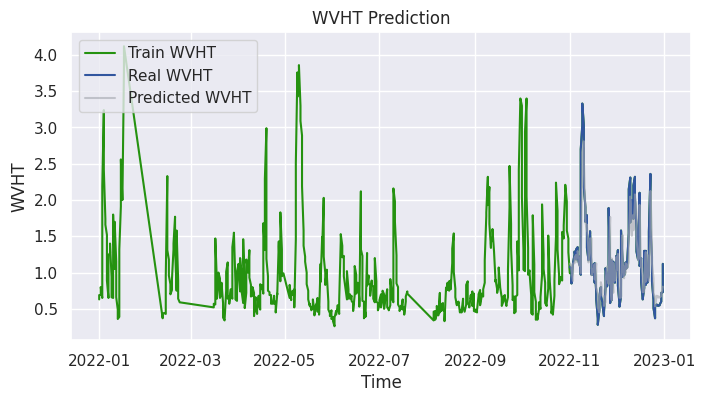

In [ ]:
# @title
plt.figure(figsize=(8, 4))
plt.plot(windWave.index[-4000:], windWave['WVHT'].tail(4000), color='#259210', label = 'Train WVHT')
plt.plot(WWtest.index, y, color = '#31569f', label = 'Real WVHT')
plt.plot(WWtest.index, predictions,color='#a3a7af', alpha=0.6, label = 'Predicted WVHT')
plt.title('WVHT Prediction')
plt.xlabel('Time')
plt.ylabel('WVHT')
plt.legend()
plt.show()

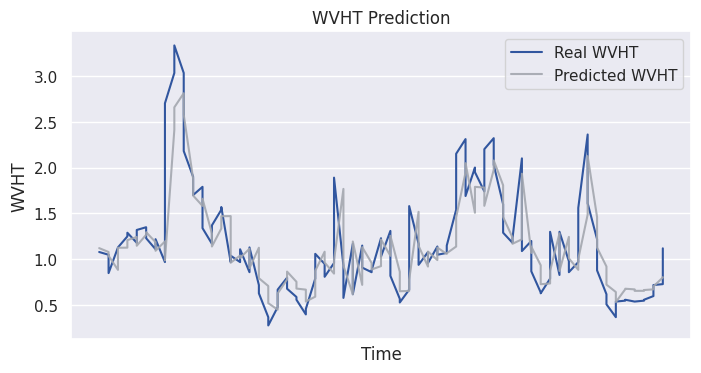

In [ ]:
# @title
plt.figure(figsize=(8, 4))
plt.plot(WWtest.index, y, color = '#31569f', label = 'Real WVHT')
plt.plot(WWtest.index, predictions,color='#a3a7af', alpha=0.9, label = 'Predicted WVHT')
plt.title('WVHT Prediction')
plt.xlabel('Time')
plt.ylabel('WVHT')
plt.xticks([])
plt.legend()
plt.show()

# Tensor Flow

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [ ]:
n = len(windWave)
train_df = windWave[0:int(n*0.8)]
test_df = windWave[int(n*0.8):]


num_features = windWave.shape[1]

train_df.shape,test_df.shape,num_features

((481, 6), (121, 6), 6)

In [ ]:
# Normalize the data by scaling which is done by subtracting the mean and divide by the STD of each feature
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


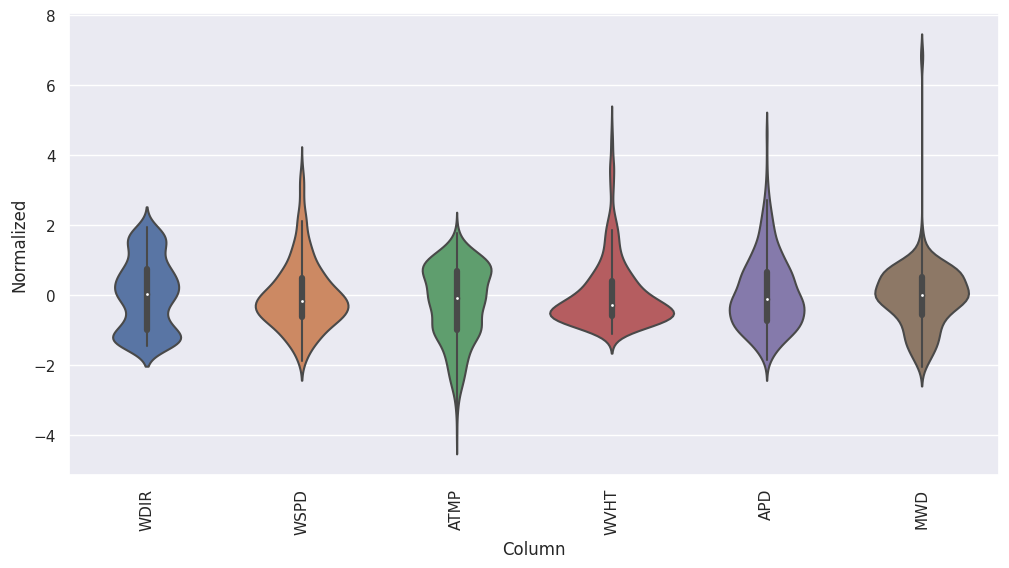

In [ ]:
# exclude_columns = ['PRES', 'ATMP']
selected_columns = [col for col in windWave.columns]
df_std1 = (windWave[selected_columns] - train_mean[selected_columns]) / train_std[selected_columns]
df_std1 = df_std1.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std1)
_ = ax.set_xticklabels(selected_columns, rotation=90)

In [ ]:
windWave

,WDIR,WSPD,ATMP,WVHT,APD,MWD
2022-01-01,157.0,4.1,12.8,0.63,7.63,94.0
2022-01-01,196.0,4.8,17.0,0.69,6.79,87.0
2022-01-02,198.0,8.6,19.8,0.69,4.84,66.0
2022-01-02,224.0,10.0,19.5,0.80,4.00,79.0
2022-01-03,270.0,4.9,18.6,0.65,5.90,71.0
...,...,...,...,...,...,...
2022-12-29,235.0,3.8,4.8,0.56,8.16,107.0
2022-12-30,190.0,6.0,11.4,0.60,6.67,96.0
2022-12-30,190.0,6.0,11.1,0.72,8.59,102.0
2022-12-31,172.0,5.4,17.9,0.73,6.42,109.0


In [ ]:
# Time series data must be divided into X_train and y_train so we can turn time series into a supervised learning problem
# which can be train the model, The loop generates input/output sequences of 25

X_train = []
y_train = []

data = train_df.values

X_train = train_df.iloc[:,[0, 1, 2, 4, 5]].values
y_train = train_df.iloc[:,[3]].values

X_train.shape,y_train.shape

((481, 5), (481, 1))

In [ ]:
X_test = []
y_test = []

X_test = test_df.iloc[:,[0, 1, 2, 4, 5]].values
y_test = test_df.iloc[:,[3]].values

X_test.shape,y_test.shape

((121, 5), (121, 1))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)

past = 20 # Predicting from the past n days
future =  2 # Predicting for the next n day(s)
sequence_length = int(past) # How far back the model will go to make predictions
batch_size = 32 # n samples from training set will be used to estimate error before weights are updated

# A low batch size results in noisy estimates and weights A large batch size you get few updates and take longer to converge and get good values


In [ ]:
np.random.seed(42)
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
#   sampling_rate=step,# Used to grab obsevations every so often so we didnt have to do it manually
    batch_size=batch_size,
)

In [ ]:
np.random.seed(42)
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 20, 5)
Target shape: (32, 1)


In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])) # Defines input layer of the model (Number of time steps, number of features)

dropout_rate = 0.2  # Adjust the dropout rate as needed
dropout_layer = keras.layers.Dropout(rate=dropout_rate)(inputs)

lstm_out = keras.layers.LSTM(32)(dropout_layer) # Defines LSTM layer with 32 nuerons (units) which takes in inputs
outputs = keras.layers.Dense(1)(lstm_out) # Defines fully connected layer with single output unit which takes in output of lstm
learningRate = .001

model = keras.Model(inputs=inputs, outputs=outputs) # Creates model defining input/output
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learningRate), loss="mse") # Compiles model with Adam, MSE, a LR of .001 currently
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 5)]           0         
                                                                 
 dropout (Dropout)           (None, 20, 5)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4897 (19.13 KB)
Trainable params: 4897 (19.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=1) # Callback to interrupt training when validation loss is not improving
# Monitor val loss, minimum change is 0, stops if no chane after 3 epochs
epochs = 20


history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_test,
    callbacks=[es_callback],
);

Epoch 1/20
15/15 [==============================] - 2s 45ms/step - loss: 1.0250 - val_loss: 0.9056
Epoch 2/20
15/15 [==============================] - 0s 18ms/step - loss: 0.9335 - val_loss: 0.8334
Epoch 3/20
15/15 [==============================] - 0s 18ms/step - loss: 0.9185 - val_loss: 0.8058
Epoch 4/20
15/15 [==============================] - 0s 21ms/step - loss: 0.8978 - val_loss: 0.7968
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 0.8793 - val_loss: 0.7780
Epoch 6/20
15/15 [==============================] - 0s 20ms/step - loss: 0.8550 - val_loss: 0.7499
Epoch 7/20
15/15 [==============================] - 0s 21ms/step - loss: 0.8366 - val_loss: 0.7065
Epoch 8/20
15/15 [==============================] - 0s 21ms/step - loss: 0.7787 - val_loss: 0.6436
Epoch 9/20
15/15 [==============================] - 0s 16ms/step - loss: 0.7488 - val_loss: 0.5779
Epoch 10/20
15/15 [==============================] - 0s 18ms/step - loss: 0.6957 - val_loss: 0.5431
Epoch 11/

In [ ]:
X_test.shape,y_test.shape,X_train.shape,y_train.shape
# X_testRE = np.reshape(X_test, (0, 60, 8))

((121, 5), (121, 1), (481, 5), (481, 1))

In [ ]:
evaluationTest = model.evaluate(dataset_test)
evaluationTest

4/4 [==============================] - 0s 6ms/step - loss: 0.4930


0.4930386245250702

In [ ]:
evaluationTrain = model.evaluate(dataset_train)
evaluationTrain

15/15 [==============================] - 0s 6ms/step - loss: 0.5052


0.5052107572555542

## **Initial Model Eval**
The inital model produced a

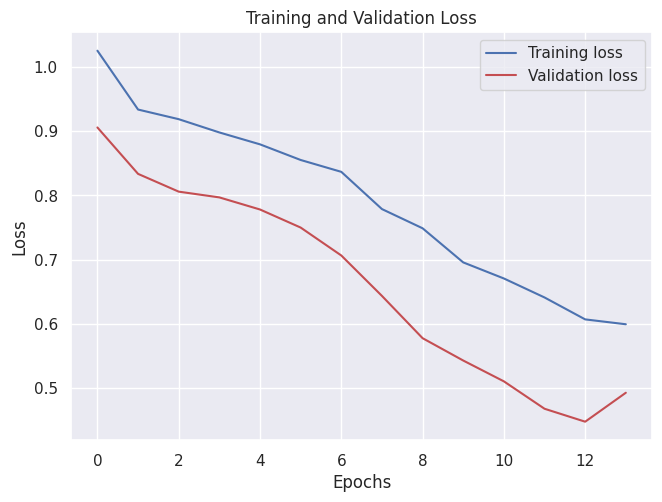

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [ ]:
dataset_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

1/1 [==============================] - 0s 323ms/step


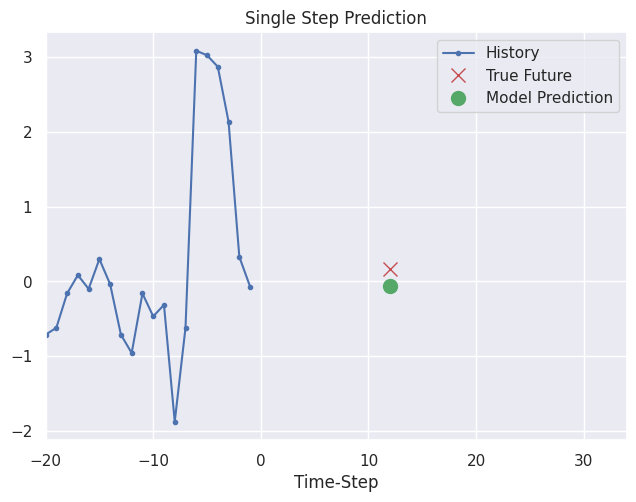

1/1 [==============================] - 0s 16ms/step


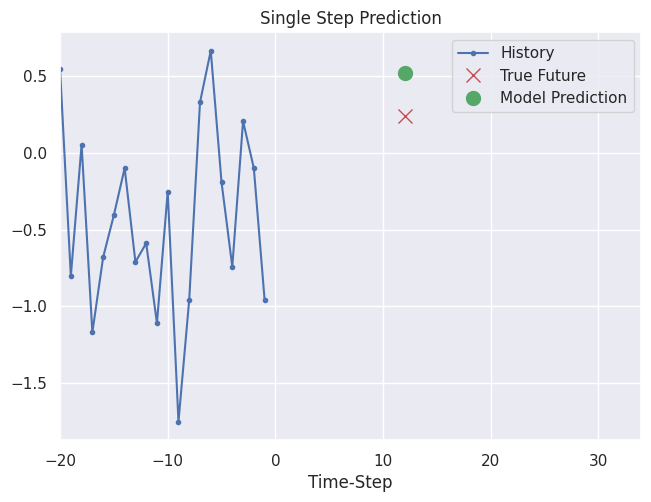

1/1 [==============================] - 0s 17ms/step


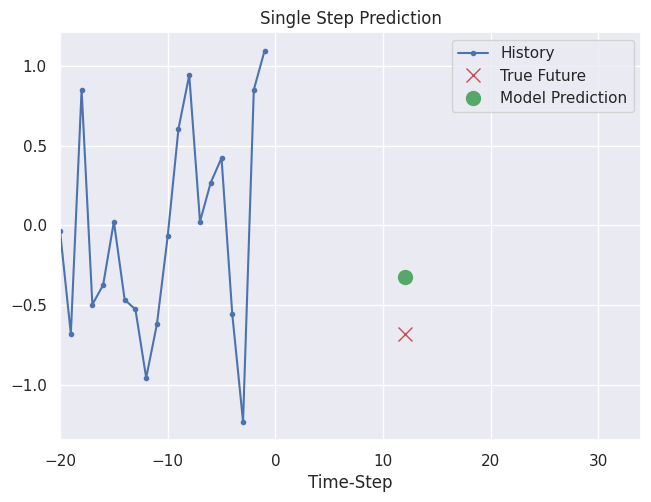

1/1 [==============================] - 0s 286ms/step


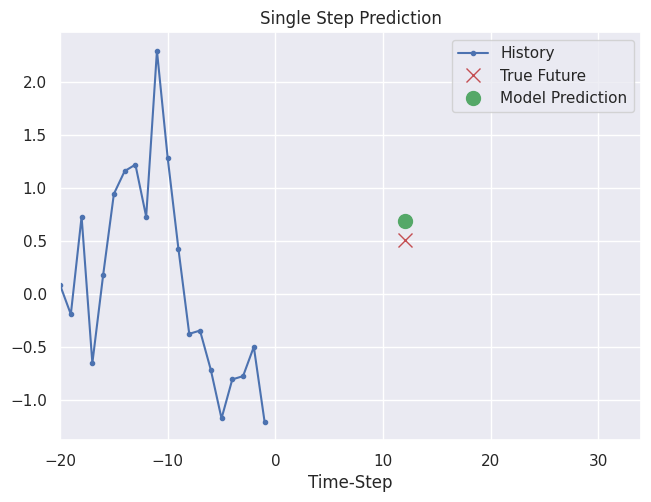

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

# Things I did to improve model

Added a drop out rate

Changed the past and future dates

Added a callback to the model

Change BatchSize

Took out GST since it was correlated with WSPD
